# Sensor Based Activity Recoginition 
Challenge: cdl1 - Sensor based Activity Recognition  
Team: Lea Bütler, Manjavy Kirupa, Etienne Roulet, Si Ben Tran  

Aufgabe: DL Modell erstellen

Hier in diesem Notebook erstellen wir unsere Deep Learning Modelle.

In [23]:
import tensorflow as tf
from sklearn.model_selection import KFold
import numpy as np
import logging
from datetime import datetime
import dataclasses
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import os
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np

tf.debugging.set_log_device_placement(False)

# datetime as filename for logging
now = datetime.now()
date_time_string = now.strftime("%Y-%m-%d_%H-%M-%S")

logging.basicConfig(level=logging.INFO, filename = f"{date_time_string}.txt", filemode='a')
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Daten einlesen

In [24]:
from dataclasses import dataclass
# Static Parameters
@dataclass
class Parameters():
    batch_size: int = 128
    epochs: int = 10
    verbosity: str = "auto"
    step_size: int = 374
    number_folds: int = 2
    output_size: int = 6

In [25]:
df = pd.read_csv("../Sensor_Data-Wrangling-und-EDA/Alle_Messungen_trimmed.csv") 
df.head()

,Unnamed: 0,time,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Orientation_qx,Orientation_qy,Orientation_qz,id,user,class,id_combined
0,1,2023-02-27 15:02:17.156,0.000,9.722,1.278,0.0,0.0,0.0,0.000000,0.0,0.000000,-0.21775,-0.719579,0.631111,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
1,2,2023-02-27 15:02:31.574,-0.728,9.779,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,-0.42065,0.568356,-0.598058,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
2,3,2023-02-27 15:02:16.685,0.000,0.000,0.000,0.0,0.0,0.0,0.000000,43.5,-13.143750,0.00000,0.000000,0.000000,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
3,4,2023-02-27 15:02:32.295,0.000,0.000,0.000,0.0,0.0,0.0,-13.012501,0.0,20.587502,0.00000,0.000000,0.000000,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
4,5,2023-02-27 15:02:33.285,0.000,0.000,0.000,0.0,0.0,0.0,-22.612501,0.0,20.268751,0.00000,0.000000,0.000000,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen


In [26]:
# convert the string time column to datetime
epoch = pd.Timestamp('1970-01-01')

df['time'] = pd.to_datetime(df['time'])
df['time'] = (df['time'] - epoch).apply(lambda x: int(x.total_seconds() * 1000))

print(df.shape)

(2344488, 18)


In [27]:
# select etiennes laufen dataset 01
df_etienne = df[df["id_combined"] == "01_iPhone13pro-2023-03-21_16-55-47Etienne_RouletLaufen"]
# split df_etienne into 2 parts 
df_etienne_laufen = df_etienne.sample(frac=0.6, random_state=42)
print(df_etienne_laufen.shape)

# export to csv
df_etienne_laufen.to_csv("Etienne_Messung_Laufen.csv", index=False)

# remove rows from df that are in df_etienne_laufen
df = df.drop(df_etienne_laufen.index)

# print new shape of df
print(df.shape)

(4063, 18)
(2340425, 18)


In [28]:
df = df.drop(columns=["id", "user", "id_combined"])
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# get all types of the df
le = LabelEncoder()
df["class"] = le.fit_transform(df["class"])
# print dictionary of the classes and its encoded values
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Laufen': 0, 'Rennen': 1, 'Sitzen': 2, 'Stehen': 3, 'Treppenlaufen': 4, 'Velofahren': 5}


In [29]:
# Set the window size and step size
window_size = 300
step_size = 100

# Reshape X to 2D format (samples, features)
X = df.values[:, 1:13]

# Define y
y = df["class"].values

# Create a sliding window of X with the specified window and step sizes
X_windows = np.array([X[i:i+window_size,:] for i in range(0,X.shape[0]-window_size+1,step_size)])

# Reshape X_windows to 3D format (samples, timesteps, features)
timesteps = X_windows.shape[1]
n_features = X_windows.shape[2]
X_windows = X_windows.reshape(-1, timesteps, n_features)

# Create the corresponding y labels for the sliding windows
y_windows = np.array([y[i+window_size-1] for i in range(0,X.shape[0]-window_size+1,step_size)])
y_windows = to_categorical(y_windows, num_classes=6)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.2, random_state=42, stratify=y_windows)


In [30]:
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2340425, 12),
 (2340425,),
 (18721, 300, 12),
 (18721, 6),
 (4681, 300, 12),
 (4681, 6))

In [31]:
x_train = X_train
x_test = X_test
y_train = y_train
y_test = y_test

In [39]:
# Something like this as first Model

# Something like this as Third Model
def create_model_3(name="model_3"):
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((-1, 12), input_shape=(12,)),
        tf.keras.layers.Conv1D(32, 5, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv1D(16, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='softmax')
    ], name=name)
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    return model

def create_model_4(name="model_4"):
    model = tf.keras.Sequential([
        # Add a 1D convolutional layer
        tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', input_shape=(timesteps, n_features)),
        
        # Add LSTM layer
        tf.keras.layers.LSTM(100),

        # Add a dense output layer
        tf.keras.layers.Dense(6, activation='softmax')  # Change activation function based on the nature of the output
    ], name=name)
    model.compile(optimizer='adam',   loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])  
    return model

def create_model_5(name="model_5"):
    model = tf.keras.Sequential([
        # Add a 1D convolutional layer
        tf.keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', padding='same', input_shape=(timesteps, n_features)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=6, kernel_size=2, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2),

        # flatten output
        tf.keras.layers.Flatten(),

        # Add a dense output layer
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')  # Change activation function based on the nature of the output
    ], name=name)

    model.compile(optimizer='adam',   loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

In [40]:
best_model_history = None  # Keep track of the best model's history
model_histories = []
# Perform cross-validation
models = [create_model_4, create_model_5]
best_model = None
num_folds = Parameters.number_folds
tscv = TimeSeriesSplit(n_splits=num_folds)
fold_acc_scores = []


for i, (train, test) in enumerate(tscv.split(x_train)):
    logging.info(f'Fold {i+1}')
    train_x, train_y = x_train[train], y_train[train]
    test_x, test_y = x_train[test], y_train[test]
    
    fold_histories = []

    
    for j, model_creator in enumerate(models):
        print(f"Model {model_creator.__name__}")
        model_name = f"Model_{j+1}_Fold_{i+1}"
        model = model_creator(name=model_name)
        logging.info(f'Model {j+1}')
        history = model.fit(train_x, train_y, epochs=Parameters.epochs, batch_size=Parameters.batch_size, validation_data=(test_x, test_y), verbose=Parameters.verbosity)
        test_loss, acc, prec, recal = model.evaluate(test_x, test_y, verbose=Parameters.verbosity)
        logging.info(f'Validation accuracy: {acc}')
        
        fold_histories.append(history.history)
        
        for epoch in range(Parameters.epochs):
            # Log accuracy after each epoch
            acc_epoch = history.history['val_accuracy'][epoch]
            logging.info(f'Epoch {epoch + 1}, Validation accuracy: {acc_epoch}')
        fold_acc_scores.append((i, j, acc))
        
        if best_model_history is None or acc > best_model_acc:
            best_model_history = history
            best_model = model  # Store the trained model instance
            best_model_acc = acc
    
    model_histories.append(fold_histories)

# Find the best model
best_model_index = np.argmax([score[2] for score in fold_acc_scores])
best_fold_idx, best_model_idx, _ = max(fold_acc_scores, key=lambda x: x[2])
best_model_history = model_histories[best_fold_idx][best_model_idx]
print(best_model.name)

Model create_model_4
Epoch 1/10
49/49 [==============================] - 7s 108ms/step - loss: 1.2982 - accuracy: 0.4980 - precision_17: 0.7430 - recall_17: 0.2214 - val_loss: 1.0507 - val_accuracy: 0.6412 - val_precision_17: 0.8585 - val_recall_17: 0.3402
Epoch 2/10
49/49 [==============================] - 4s 83ms/step - loss: 0.9107 - accuracy: 0.6845 - precision_17: 0.8370 - recall_17: 0.4672 - val_loss: 0.7623 - val_accuracy: 0.7551 - val_precision_17: 0.8505 - val_recall_17: 0.5905
Epoch 3/10
49/49 [==============================] - 4s 79ms/step - loss: 0.6787 - accuracy: 0.7762 - precision_17: 0.8735 - recall_17: 0.6485 - val_loss: 0.6194 - val_accuracy: 0.7936 - val_precision_17: 0.8605 - val_recall_17: 0.7008
Epoch 4/10
49/49 [==============================] - 4s 77ms/step - loss: 0.5221 - accuracy: 0.8353 - precision_17: 0.9017 - recall_17: 0.7481 - val_loss: 0.4971 - val_accuracy: 0.8346 - val_precision_17: 0.8877 - val_recall_17: 0.7649
Epoch 5/10
49/49 [====================

In [38]:
print(best_model.name)

sequential_15


[1.0202075242996216, 0.49514561891555786, 0.36048176884651184, 0.27627015113830566, 0.24819490313529968, 0.20942606031894684, 0.18308234214782715, 0.16555391252040863, 0.17524702847003937, 0.13404244184494019]


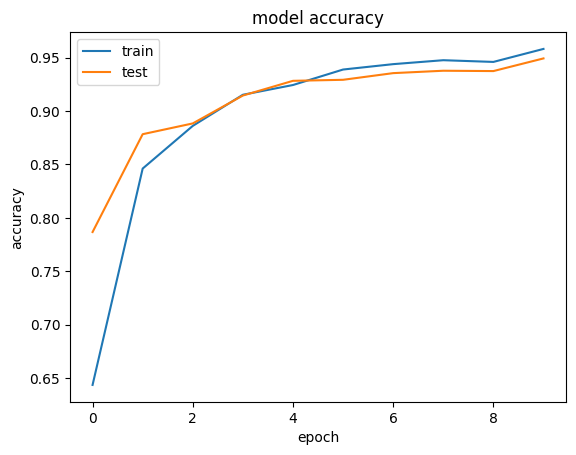

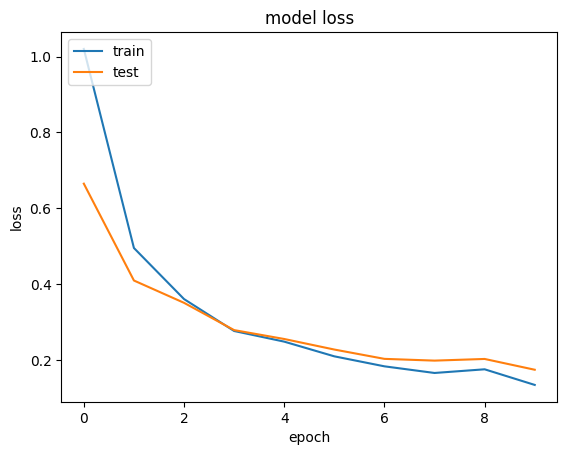

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

print(best_model_history['loss'])
# summarize history for accuracy
plt.plot(best_model_history['accuracy'])
plt.plot(best_model_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(best_model_history['loss'])
plt.plot(best_model_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

147/147 [==============================] - 3s 16ms/step


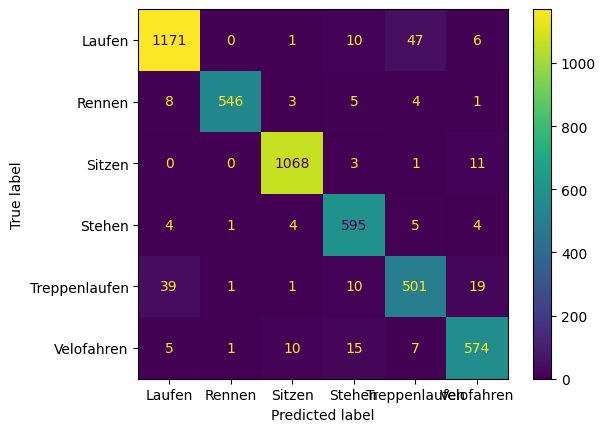

array([0.95125914, 0.97849462, 0.9843318 , 0.95123901, 0.88204225,
       0.93561532])

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#for multiclass classification
y_pred = best_model.predict(x_test)
y_test_labels = y_test.argmax(axis=1)
y_pred_labels = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
# get f1 score of each class
from sklearn.metrics import f1_score
f1 = f1_score(y_test_labels, y_pred_labels, average=None)
# get f1 score of each class

disp.plot()
plt.show()
display(f1)

In [42]:
df_etienne = pd.read_csv("Eitenne_Messungen_Laufen.csv")
df_etienne = df_etienne.drop(columns=["id", "user", "id_combined"])
# convert the string time column to datetime
epoch = pd.Timestamp('1970-01-01')
df_etienne['time'] = pd.to_datetime(df_etienne['time'])
df_etienne['time'] = (df_etienne['time'] - epoch).apply(lambda x: int(x.total_seconds() * 1000))
df_etienne.drop(['Unnamed: 0'], axis=1, inplace=True)
# get all types of the df
le = LabelEncoder()
df_etienne["class"] = le.fit_transform(df_etienne["class"])

In [ ]:
le.classes_

In [43]:
# Set the window size and step size
window_size = 300
step_size = 100

# Reshape X to 2D format (samples, features)
X = df_etienne.values[:, 1:13]

# Create a sliding window of X with the specified window and step sizes
X_windows = np.array([X[i:i+window_size,:] for i in range(0,X.shape[0]-window_size+1,step_size)])

# Reshape X_windows to 3D format (samples, timesteps, features)
timesteps = X_windows.shape[1]
n_features = X_windows.shape[2]
X_windows = X_windows.reshape(-1, timesteps, n_features)

y_pred_probs = best_model.predict(X_windows)

# Get the predicted class labels for each input window
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Print the predicted class labels
# get the median of the predicted labels
sol = np.median(y_pred_labels)

class_counts = np.bincount(y_pred_labels)
for i, count in enumerate(class_counts):
    print(f"Class {i} count: {count}")


2/2 [==============================] - 0s 129ms/step
Class 0 count: 27
Class 1 count: 0
Class 2 count: 0
Class 3 count: 0
Class 4 count: 11


In [49]:
# export Model to json Tensorflow file
import json
best_model.save('saved_model/sensor_model.h5')

model = tf.keras.models.load_model('saved_model/sensor_model.h5')

# Save model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to a JSON file
weights = model.get_weights()
weights_as_list = [w.tolist() for w in weights]
with open("weights.json", "w") as f:
    json.dump(weights_as_list, f)


NameError: name 'json' is not defined